In [1]:
import wandb
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from tqdm import tqdm
from torchtext.legacy.data import TabularDataset
from torchtext.legacy.data import Field, BucketIterator
import pandas as pd


train_path = "mal/mal_train.csv"
valid_path = "mal/mal_valid.csv"
test_path  =  "mal/mal_test.csv"



#correct_path = "without_attention/correct.csv"
#incorrect_path = "without_attention/incorrect.csv"
correct_path = "with_attention/correct.csv"
incorrect_path = "with_attention/incorrect.csv"


def tokenize(word):
    return list(word)


def get_datasets(device, batch_size=2):
    

    # Create the pytext's Field
    source_field = Field(tokenize=tokenize,
                    init_token='<sos>', 
                    eos_token='<eos>', 
                    pad_token="<pad>",
                    unk_token="<unk>",
                    lower=False)
    target_field = Field(tokenize=tokenize,
                    init_token='<sos>',
                    eos_token='<eos>',
                    pad_token="<pad>",
                    unk_token="<unk>",
                    )

    # Splits the data in Train, Test and Validation data
    train_set, valid_set, test_set = TabularDataset.splits(
        path="",
        train=train_path,
        validation=valid_path,
        test=test_path,
        format="csv",
        csv_reader_params={"delimiter": ",", "skipinitialspace": True},
        fields=[("src", source_field), ("trg", target_field)],)

    # Build the vocabulary for both the language
    source_field.build_vocab(train_set, min_freq=3)
    target_field.build_vocab(train_set, min_freq=3)

    # Create the Iterator using builtin Bucketing
    train_iterator, valid_iterator, test_iterator = BucketIterator.splits((train_set,\
                                                valid_set, test_set),
                                                batch_size=batch_size,
                                                sort_within_batch=True,
                                                sort_key=lambda x: len(x.src),
                                                device=device)
    return train_iterator, valid_iterator, test_iterator, source_field, target_field




In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
batch_size = 2
train_iterator, valid_iterator, test_iterator, source, target = get_datasets(device, batch_size)
  

In [4]:
class Encoder_GRU(nn.Module):
    def __init__(self, input_dim, emb_dim, hidden_dim, dropout):
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        
        self.rnn = nn.GRU(emb_dim, hidden_dim, bidirectional = True)
        
        self.fc = nn.Linear(hidden_dim * 2, hidden_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        
        #src = [src len, batch size]
        
        embedded = self.dropout(self.embedding(src))
        
        #embedded = [src len, batch size, emb dim]
        
        outputs, hidden = self.rnn(embedded)
                
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))
                
        return outputs, hidden

In [5]:
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        
        self.U = nn.Linear((hidden_dim * 2) + hidden_dim, hidden_dim)
        self.V = nn.Linear(hidden_dim, 1, bias = False)
        
    def forward(self, hidden, encoder_outs):
        
        
        batch_size = encoder_outs.shape[1]
        src_len = encoder_outs.shape[0]
        
        
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        
        encoder_outs = encoder_outs.permute(1, 0, 2)    
        
        
        energy = torch.tanh(self.U(torch.cat((hidden, encoder_outs), dim = 2))) 
        
        att_score = self.V(energy).squeeze(2)
        att_weights = torch.softmax(att_score, dim=1)
        
        #attention= [batch size, src len]
        
        return att_weights

In [6]:
class Decoder_GRU(nn.Module):
    def __init__(self, output_dim, emb_dim, hidden_dim, dropout, attention):
        super().__init__()

        self.output_dim = output_dim
        self.attention = attention
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.GRU((hidden_dim * 2) + emb_dim, hidden_dim)
        
        self.fc_out = nn.Linear((hidden_dim * 2) + hidden_dim + emb_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, encoder_outs):
             
        #input = [batch size]
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        
        input = input.unsqueeze(0)
        
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        
        #embedded = [1, batch size, emb dim]
        
        att_wts = self.attention(hidden, encoder_outs)
                
        #a = [batch size, src len]
        
        att_wts = att_wts.unsqueeze(1)
        
        #a = [batch size, 1, src len]
        
        encoder_outs = encoder_outs.permute(1, 0, 2)
        
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        
        weighted_embed = torch.bmm(att_wts, encoder_outs)
        
        #weighted = [batch size, 1, enc hid dim * 2]
        
        weighted_embed = weighted_embed.permute(1, 0, 2)
        
        #weighted = [1, batch size, enc hid dim * 2]
        
        rnn_input = torch.cat((embedded, weighted_embed), dim = 2)
        
        #rnn_input = [1, batch size, (enc hid dim * 2) + emb dim]
            
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        
        
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted_embed = weighted_embed.squeeze(0)
        
        prediction = self.fc_out(torch.cat((output, weighted_embed, embedded), dim = 1))
        
        #prediction = [batch size, output dim]
        
        return prediction, hidden.squeeze(0), att_wts

In [7]:
class Seq2Seq_GRU(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        
        #src = [src len, batch size]
        #trg = [trg len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use teacher forcing 75% of the time
        
        batch_size = src.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        #encoder_outputs is all hidden states of the input sequence, back and forwards
        #hidden is the final forward and backward hidden states, passed through a linear layer
        encoder_outs, hidden = self.encoder(src)
                
        #first input to the decoder is the <sos> tokens
        input = trg[0,:]
        att_list = []
        for t in range(1, trg_len):
            
            #insert input token embedding, previous hidden state and all encoder hidden states
            #receive output tensor (predictions) and new hidden state
            output, hidden, att_wts = self.decoder(input, hidden, encoder_outs)
            att_list.append(att_wts)
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trg[t] if teacher_force else top1
        #print(type(att_wts), att_wts.shape)

        return outputs, att_list

LSTM

In [8]:
def train(model, iterator, optimizer, criterion, clip,teacher_forcing_ratio):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output, att_list = model(src, trg)
        
        #trg = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        
        output_dim = output.shape[-1]
        
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        
        #trg = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [9]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output, att_list = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            #trg = [(trg len - 1) * batch size]
            
            #output = [(trg len - 1) * batch size, output dim]
            
            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [10]:
import matplotlib.pyplot as plt
#plt.switch_backend('agg')
import matplotlib.ticker as ticker
import matplotlib.font_manager as fm

def showAttention(input_word, output_word, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions, cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    prop = fm.FontProperties(fname='AnjaliOldLipi-Regular.ttf')
    ax.set_xticklabels(['']+input_word, rotation=90)
    ax.set_yticklabels([''] + output_word,fontproperties=prop)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()





In [11]:
def predict_word(device, model, source, target, src, trg):
    #print(src, trg)
    src_tensor = source.process([src]).to(device)
    trg_tensor = target.process([trg]).to(device)
    #print(src_tensor)
  
    model.eval()
    with torch.no_grad():
      outputs, att_list = model(src_tensor, trg_tensor, teacher_forcing_ratio=0)
    output_ids = outputs[1:].squeeze(1).argmax(1)
    output_tokens = [target.vocab.itos[idx] for idx in output_ids]
    return output_tokens, att_list
    

def predict(device, model, iterator, source, target, testfile, correct_path, incorrect_path, save_pred, show_att):
    src_words_correct = []
    trg_words_correct = []
    pred_words_correct = []
    src_words_incorrect = []
    trg_words_incorrect = []
    pred_words_incorrect = []
    src_vocab = source.vocab
    trg_vocab = target.vocab
    test_data = pd.read_csv(testfile,sep=",")
    src = test_data.iloc[:,0]
    trg = test_data.iloc[:,1]
    num_predictions = len(src)
    correct_predictions = 0
    for s, t  in zip(src, trg):
        pred_word, att_list = predict_word(device, model,source, target, s, t)
        #print("pred_",pred_word)
        src_list = tokenize(s)
        trg_list = tokenize(t)
        pred_list = [item for item in pred_word if '<eos>' not in item and '<sos>' not in item]
        
        src_str = "".join(src_list)
        trg_str = "".join(trg_list)
        pred_str = "".join(pred_list)
        if show_att:
           att_tensor = torch.stack(att_list)
           att_matrix = att_tensor.numpy()
           att_matrix = np.squeeze(att_matrix)
           #print(src_list, trg_list, att_matrix.shape)
           showAttention(src_list, trg_list, att_matrix)
        if trg_list == pred_list:
            src_words_correct.append(s)
            trg_words_correct.append(t)
            pred_words_correct.append(pred_str)
            correct_predictions+=1
        else:
            src_words_incorrect.append(s)
            trg_words_incorrect.append(t)
            pred_words_incorrect.append(pred_str)
    accuracy = correct_predictions*100.0/num_predictions
    if save_pred:
      df_correct = pd.DataFrame({"source":src_words_correct, "target":trg_words_correct,\
                                    "prediction": pred_words_correct})
      df_incorrect = pd.DataFrame({"source":src_words_incorrect, "target":trg_words_incorrect,\
                                    "prediction": pred_words_incorrect})
      df_correct.to_csv(correct_path, index=False)
      df_incorrect.to_csv(incorrect_path, index=False)
      
    return accuracy

In [12]:
#Hyperparameters
lr = 0.001
batch_size =2
epochs = 5
clip = 1
rnn_type = "GRU"
bidirectional = True
teacher_forcing_ratio = 0.5
optimizer = "adam"
enc_embed_dim = 256
dec_embed_dim = 256
hidden_dim = 512
num_layers = 1
dropout_prob = 0.5
clip = 1


save_pred = False
if_test = False


config_defaults = { "lr": lr,                
        "batch_size": batch_size,
        "epochs": epochs,
        "clip": clip,
        "rnn_type" : rnn_type,
        "enc_embed_dim":enc_embed_dim,
        "hidden_dim": hidden_dim,
        "dec_embed_dim":dec_embed_dim,
        "dropout_prob": dropout_prob,
        "teacher_forcing_ratio" :teacher_forcing_ratio,
        "optimizer": optimizer
    }


sweep_config = {
        'method': 'bayes',
        'metric': {
            'name': 'validation loss',
            'goal': 'minimize'
        },
        'parameters':{
            "lr":{
              "values":[0.01, 0.001, 0.0001]
              },
            "batch_size":{
              "values":[16,64,128, 256]
              },
            "epochs":{
              "values":[50]
              },
            "clip":{
            "values":[0.5,1]
            },

            "rnn_type":{
              "values":["GRU"]
              },

            "enc_embed_dim":{
              "values":[64, 128, 256]
              },
            "dec_embed_dim":{
              "values":[32, 64,128, 256, 512]
              },
              

            "hidden_dim":{
              "values":[128, 256,512,1024 ]
              },
                      
            
            "dropout_prob":{
              "values":[0.3, 0.5, 0.7]
              },

            "teacher_forcing_ratio":{
                "values":[0.3, 0.5, 0.7]
            },         

            "optimizer":{
              "values":["adam", "nadam", "rmsprop"]
              }
      }
}

In [13]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)
        


In [14]:
def create_model_GRU(inp_dim,out_dim, enc_embed_dim,dec_embed_dim, hidden_dim, dropout_prob,\
                 source, target, lr , optm):
  attn = Attention(hidden_dim)            
  enc = Encoder_GRU(inp_dim, enc_embed_dim, hidden_dim,dropout_prob,)
  dec = Decoder_GRU(out_dim, dec_embed_dim, hidden_dim,  dropout_prob, attn)


  model = Seq2Seq_GRU(enc, dec, device).to(device)
  model.apply(init_weights)
  # Define the optimizer
  if optm == "adam":
    optimizer = optim.Adam(model.parameters(), lr=lr)
  if optm == "nadam":
    optimizer = optim.NAdam(model.parameters(), lr=lr)
  if optm == "rmsprop":
    optimizer = optim.RMSprop(model.parameters(), lr=lr)
  # CrossEntropyLoss: ignores the padding tokens.
  TARGET_PAD_IDX = target.vocab.stoi[target.pad_token]
  criterion = nn.CrossEntropyLoss(ignore_index=TARGET_PAD_IDX)

  return model, optimizer, criterion


LSTM

In [15]:
def transliterate():
  #initalize wandb with default configuaration
  wandb.init(config=config_defaults)
  config=wandb.config
  config = config_defaults
    
  
  #set wandb run name
  wandb.run.name = "e_{}_lr_{}_bs_{}_c_{}_rnn_{}_eed_{}_ded_{}_hd_{}_dr_{}_tf_{}_o{}".format(
  config["epochs"],
  config["lr"],
  config["batch_size"],
  config["clip"],
  config["rnn_type"],
  config["enc_embed_dim"],
  config["dec_embed_dim"],
  config["hidden_dim"],
  config["dropout_prob"],
  config["teacher_forcing_ratio"],
  config["optimizer"]
  ) 

  
    

    
  train_iterator, valid_iterator, test_iterator, source, target = get_datasets(device, config["batch_size"])
  inp_dim = len(source.vocab)
  out_dim = len(target.vocab)
  
  if config["rnn_type"]=="GRU":
    model, optimizer, criterion = create_model_GRU(inp_dim,out_dim, config["enc_embed_dim"],\
          config["dec_embed_dim"], config["hidden_dim"], config["dropout_prob"],\
          source, target, config["lr"],config["optimizer"])
  
  for epoch in range(config["epochs"]):
  
      
      
      train_loss = train(model, train_iterator, optimizer, criterion, config["clip"], \
                         config["teacher_forcing_ratio"])
      valid_loss = evaluate(model, valid_iterator, criterion)
      
      print(f'Epoch: {epoch}  Train Loss: {train_loss:.3f}  Val. Loss: {valid_loss:.3f} ')
      wandb.log({'train_loss':train_loss, 'valid_loss': valid_loss})
  

  
  test_loss = evaluate(model, test_iterator, criterion)
  show_att = False
  valid_acc = predict(device, model, valid_iterator, source, target, valid_path, correct_path,\
                          incorrect_path, save_pred, show_att)
  if_test=True
  if(if_test):
    test_acc = predict(device, model, test_iterator, source, target, test_path, correct_path,\
                          incorrect_path, save_pred, 0)
  show_att = True
  if(show_att):
    pred_acc =  predict(device, model, test_iterator, source, target, "mal/mal_pred.csv", correct_path,\
                          incorrect_path, save_pred, show_att)
  print(f' Test Loss: {test_loss:.3f}, valid acc:{valid_acc:.3f} testacc:{test_acc}' )
  wandb.log({'valid_accuracy':valid_acc, 'test_accuracy':test_acc, 'test_loss': test_loss})



Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: cs22d010 (deep-learning-assignment). Use `wandb login --relogin` to force relogin


Epoch: 0  Train Loss: 3.262  Val. Loss: 2.952 
Epoch: 1  Train Loss: 2.943  Val. Loss: 2.742 
Epoch: 2  Train Loss: 2.756  Val. Loss: 2.537 
Epoch: 3  Train Loss: 2.454  Val. Loss: 2.238 
Epoch: 4  Train Loss: 2.278  Val. Loss: 2.037 


/tmp/ipykernel_40112/1190257026.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+input_word, rotation=90)
/tmp/ipykernel_40112/1190257026.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_word,fontproperties=prop)


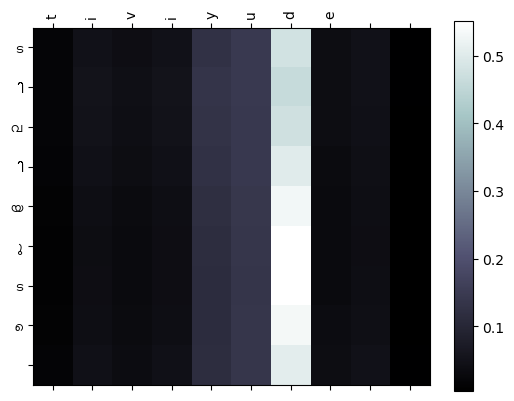

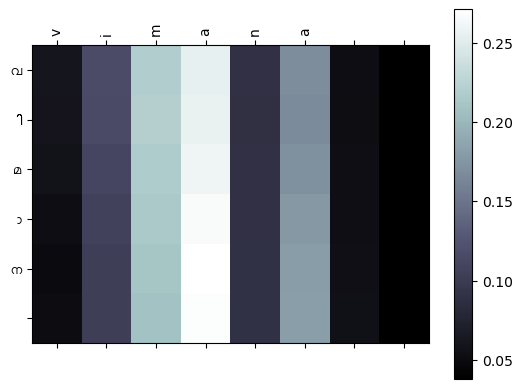

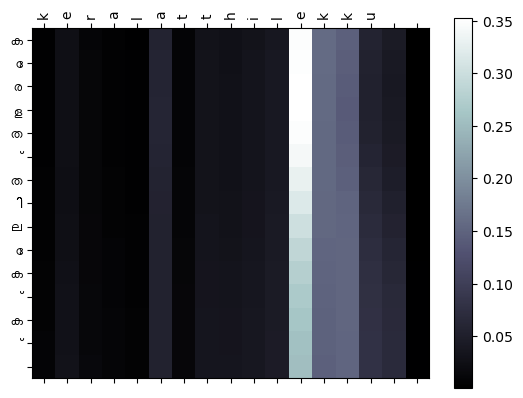

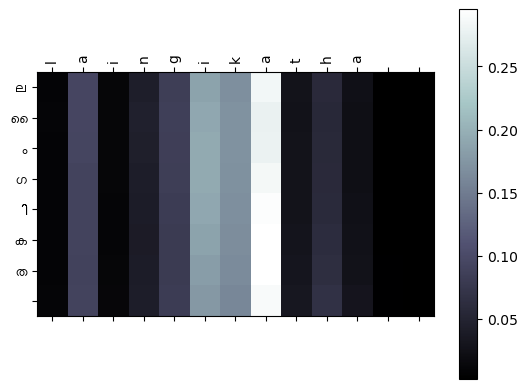

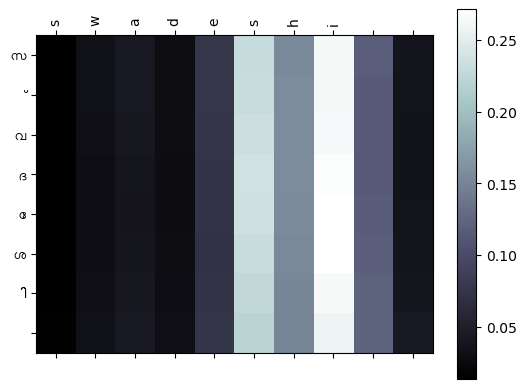

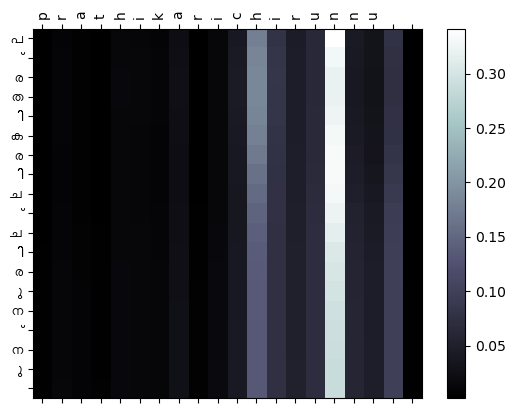

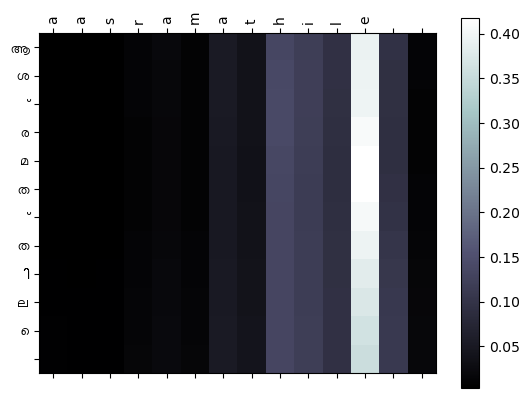

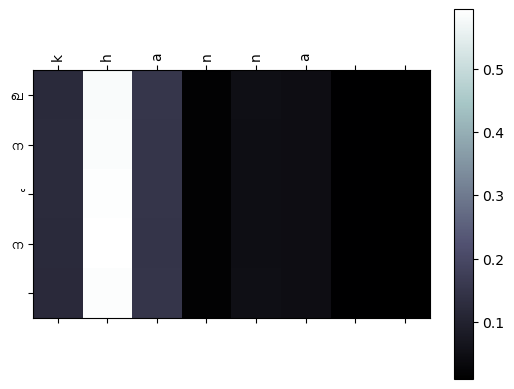

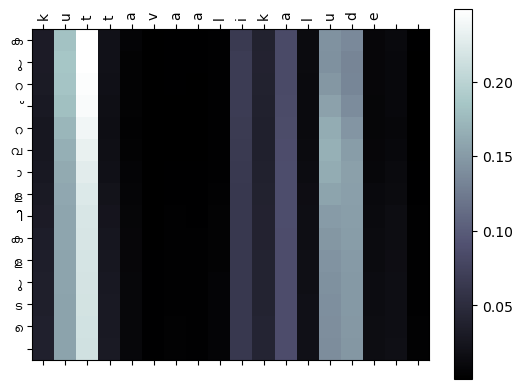

 Test Loss: 2.037, valid acc:0.000 testacc:0.0


In [16]:
transliterate()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Create sweep with ID: aa9q99cg
Sweep URL: https://wandb.ai/deep-learning-assignment/SeqToSeQ_att/sweeps/aa9q99cg
<IPython.core.display.HTML object>
<IPython.core.display.HTML object>
<IPython.core.display.HTML object>
<IPython.core.display.HTML object>


wandb: Agent Starting Run: uyup7953 with config:
wandb: 	batch_size: 128
wandb: 	clip: 0.5
wandb: 	dec_embed_dim: 32
wandb: 	dropout_prob: 0.5
wandb: 	enc_embed_dim: 256
wandb: 	epochs: 50
wandb: 	hidden_dim: 256
wandb: 	lr: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	rnn_type: GRU
wandb: 	teacher_forcing_ratio: 0.3
Exception in thread ChkStopThr:
Traceback (most recent call last):
  File "/home/rekha/anaconda3/lib/python3.9/threading.py", line 980, in _bootstrap_inner
Exception in thread NetStatThr:
Traceback (most recent call last):
  File "/home/rekha/anaconda3/lib/python3.9/threading.py", line 980, in _bootstrap_inner
    self.run()
  File "/home/rekha/anaconda3/lib/python3.9/threading.py", line 917, in run
    self.run()
  File "/home/rekha/anaconda3/lib/python3.9/threading.py", line 917, in run
    self._target(*self._args, **self._kwargs)
  File "/home/rekha/anaconda3/lib/python3.9/site-packages/wandb/sdk/wandb_run.py", line 278, in check_stop_status
    self._target(*self._args, 

Epoch: 0  Train Loss: 3.198  Val. Loss: 2.902 
Epoch: 1  Train Loss: 2.953  Val. Loss: 2.750 
Epoch: 2  Train Loss: 2.749  Val. Loss: 2.597 
Epoch: 3  Train Loss: 2.529  Val. Loss: 2.324 
Epoch: 4  Train Loss: 2.290  Val. Loss: 2.186 


/tmp/ipykernel_40112/1190257026.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+input_word, rotation=90)
/tmp/ipykernel_40112/1190257026.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_word,fontproperties=prop)


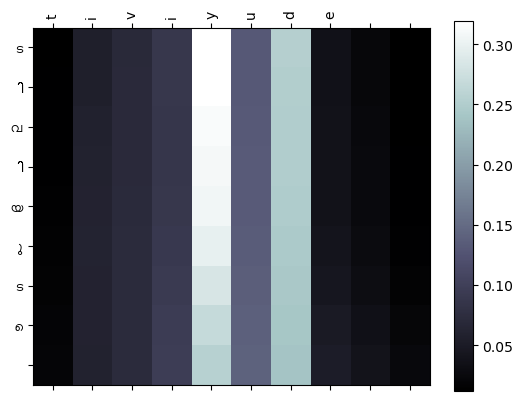

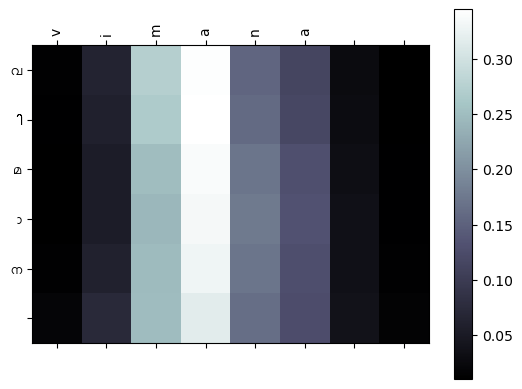

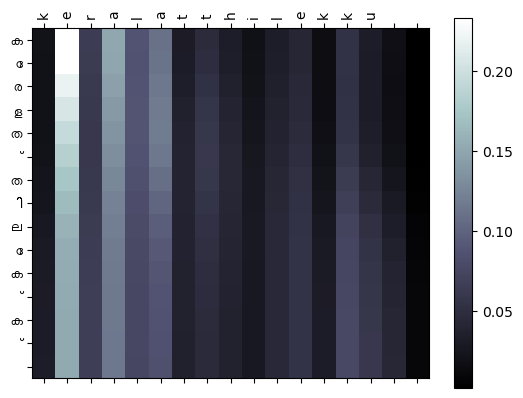

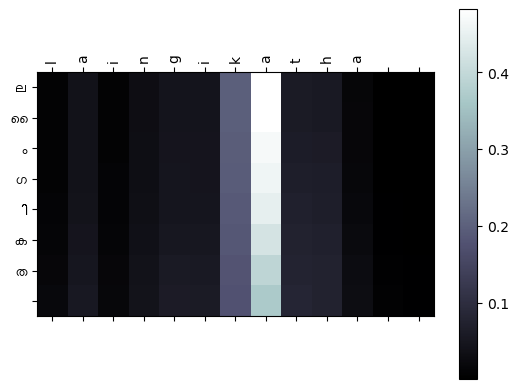

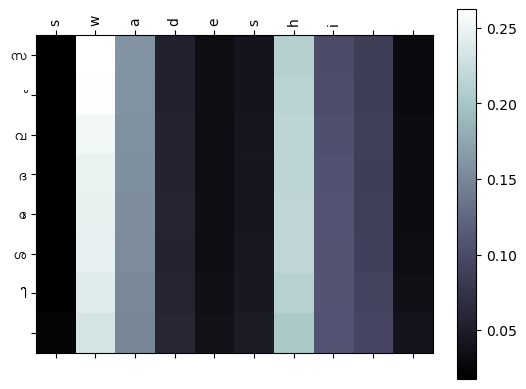

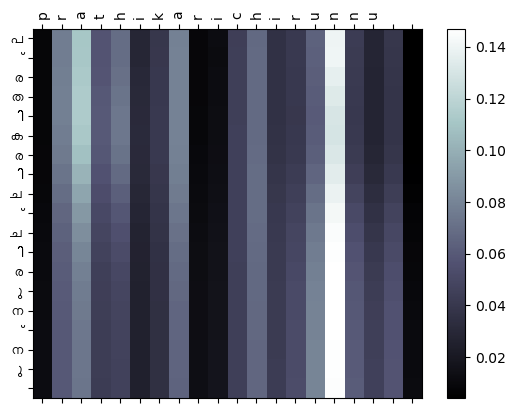

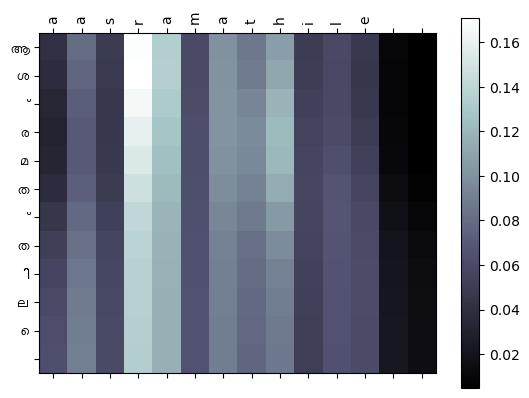

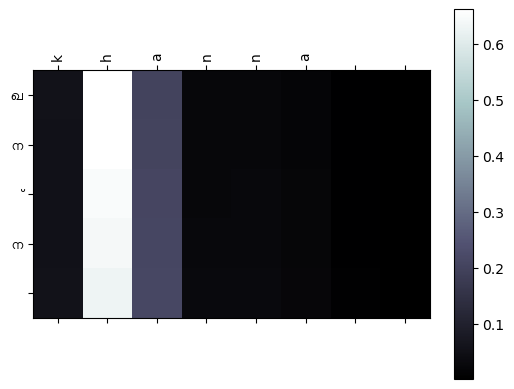

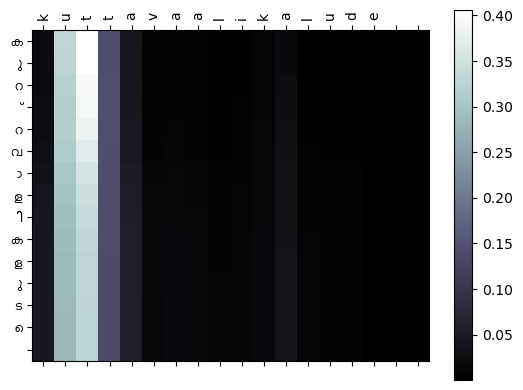

 Test Loss: 2.186, valid acc:0.000 testacc:0.0


test_accuracy,▁
test_loss,▁
train_loss,█▆▅▃▁
valid_accuracy,▁
valid_loss,█▇▅▂▁
test_accuracy,0.0
test_loss,2.18595
train_loss,2.29029
valid_accuracy,0.0
valid_loss,2.18595


wandb: Agent Starting Run: il5uh0s7 with config:
wandb: 	batch_size: 128
wandb: 	clip: 1
wandb: 	dec_embed_dim: 128
wandb: 	dropout_prob: 0.5
wandb: 	enc_embed_dim: 128
wandb: 	epochs: 50
wandb: 	hidden_dim: 512
wandb: 	lr: 0.0001
wandb: 	optimizer: nadam
wandb: 	rnn_type: GRU
wandb: 	teacher_forcing_ratio: 0.7


Epoch: 0  Train Loss: 3.211  Val. Loss: 2.945 
Epoch: 1  Train Loss: 2.898  Val. Loss: 2.847 
Epoch: 2  Train Loss: 2.737  Val. Loss: 2.499 
Epoch: 3  Train Loss: 2.451  Val. Loss: 2.186 
Epoch: 4  Train Loss: 2.192  Val. Loss: 2.111 


/tmp/ipykernel_40112/1190257026.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+input_word, rotation=90)
/tmp/ipykernel_40112/1190257026.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_word,fontproperties=prop)


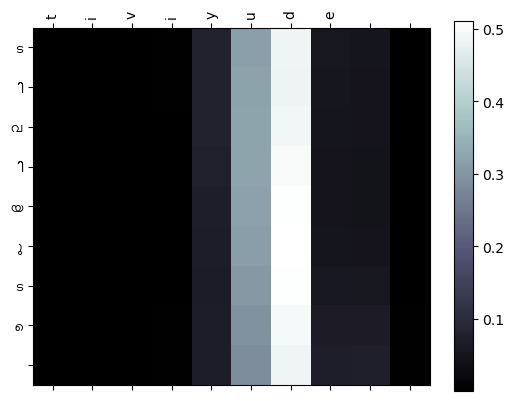

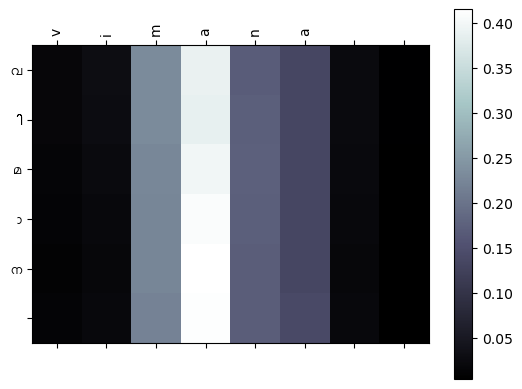

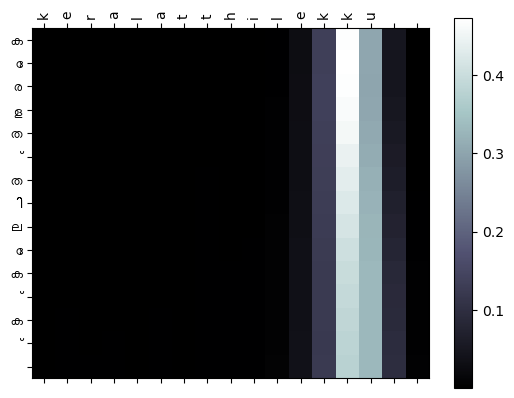

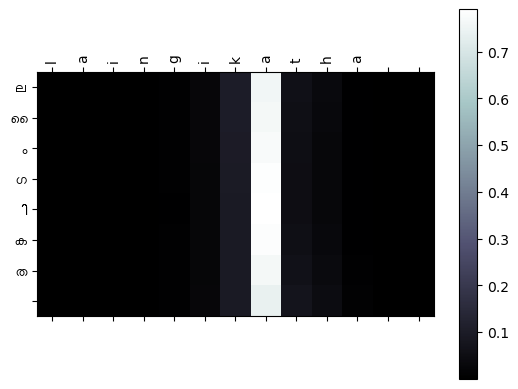

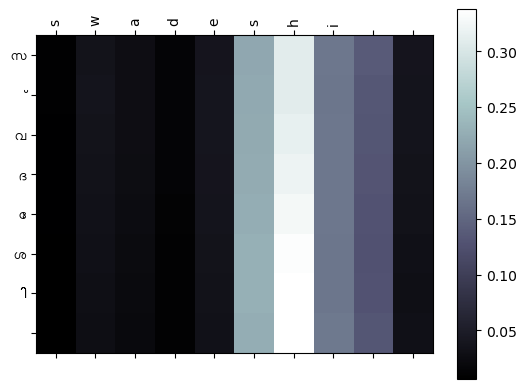

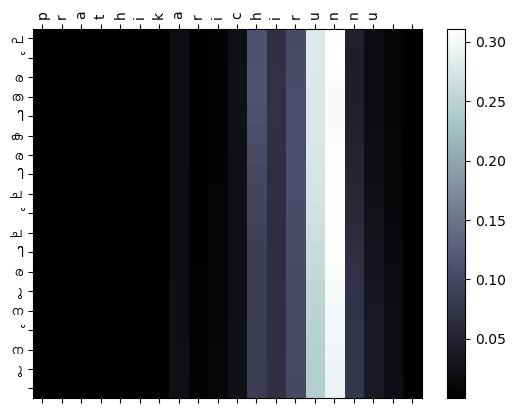

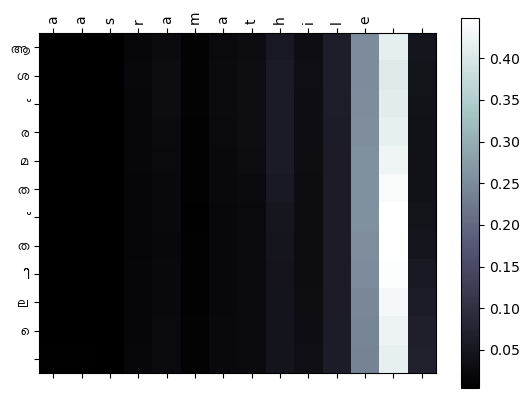

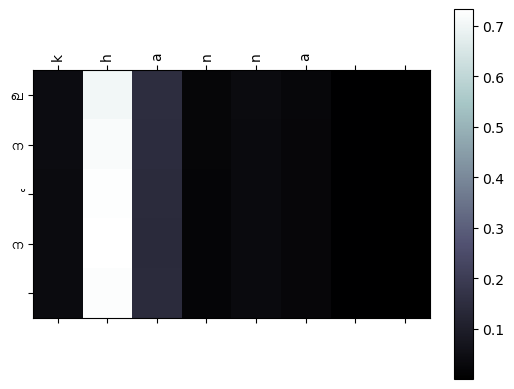

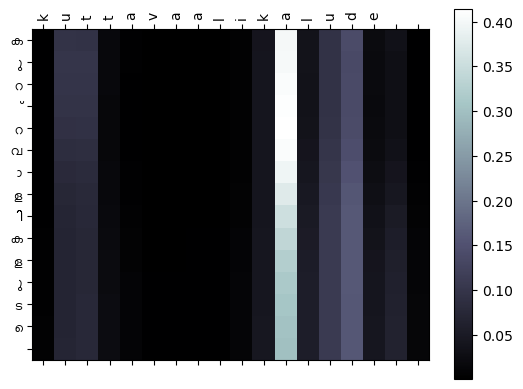

 Test Loss: 2.111, valid acc:5.263 testacc:5.2631578947368425


test_accuracy,▁
test_loss,▁
train_loss,█▆▅▃▁
valid_accuracy,▁
valid_loss,█▇▄▂▁
test_accuracy,5.26316
test_loss,2.11128
train_loss,2.19189
valid_accuracy,5.26316
valid_loss,2.11128


wandb: Ctrl + C detected. Stopping sweep.


Error in callback <function _WandbInit._pause_backend at 0x7f23002539d0> (for post_run_cell):


BrokenPipeError: [Errno 32] Broken pipe

In [17]:

#set project name
project_name = "SeqToSeQ_att"
#set entity name
entity_name = "deep-learning-assignment"
#entity_name = "dlresearchdl"
# Initialize sweep by passing in config.
sweep_id = wandb.sweep(sweep_config,project=project_name, entity=entity_name)
wandb.agent(sweep_id, function = transliterate, count=100) #for starting the job

